## Example notebook to prepare weights for trace

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import sys
import json
import os

from scipy.signal import find_peaks

In [2]:
trace_filename = '../data/traces/activation.csv'
protocol_filename = '../data/protocols/activation.csv'

In [3]:
trace = pd.read_csv(trace_filename)
protocol = pd.read_csv(protocol_filename)

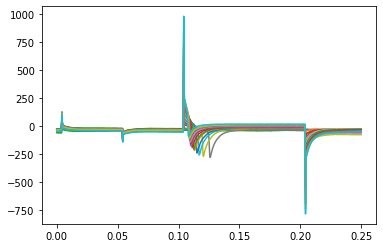

In [4]:
plt.plot(trace['t'], trace.drop('t', axis=1))
None

In [5]:
diffs = protocol.drop('t', axis = 1)[protocol.columns[-5]].diff(periods = 1).drop_duplicates()[2:]
times = protocol.t[diffs.index]

print("Times, when command potential changed in one sweep")
pd.DataFrame(times.values, columns=['t'])

Times, when command potential changed in one sweep


,t
0,0.00395
1,0.05400
2,0.10395
3,0.20400


In [6]:
t_start = 0.10395    # start time of step, in seconds
t_end = 0.15         # the approximate time when current ends, in seconds
pipette_time = 0.001 # the approximate time of pipette, in seconds

pipette_weight = 0.01 # weight for pipette part
peak_weight = 100     # weight for current part

In [7]:
dt = protocol.t[1]-protocol.t[0]
pipette_len = int(pipette_time/dt)

In [8]:
start = np.where(trace.t>=t_start)[0][0]+pipette_len
end = np.where(trace.t<=t_end)[0][-1]
len_baseline = int((end - start)/20)

In [9]:
# find peaks
data = trace.drop('t', axis=1)[start:end]
baselines = data[-len_baseline:].mean()
min_height = -(data - baselines).min().min()/5

peaks = {}
for sweep in data:
    peak = find_peaks(-data[sweep],height=min_height,distance=len(protocol))[0]
    if peak.size>0:
        peaks[sweep] = peak[0]+start

In [10]:
weight = pd.DataFrame(np.ones_like(protocol))
weight.columns = protocol.columns
weight.t = protocol.t


len_act = 0
for sweep in weight:
    if sweep =='t':
        continue
    pipette_indexes = diffs.index 
    for ind in pipette_indexes:
        weight[sweep][ind:ind+pipette_len] = pipette_weight 
    if sweep in peaks:
        peak_inds = data[sweep][data[sweep]<0].index
        peak_start = peak_inds[0]
        len_act = (peaks[sweep] - peak_start) if (peaks[sweep] - peak_start)>len_act else len_act
        peak_end = peak_inds[-1] if (peak_start+2*len_act) >= peak_inds[-1] else peak_start+2*len_act
        weight[sweep][peak_start:peak_end] = peak_weight


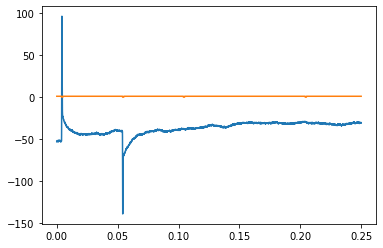

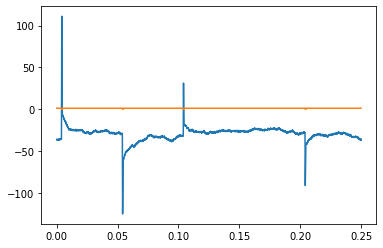

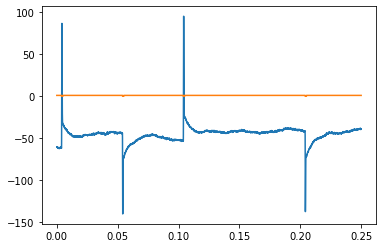

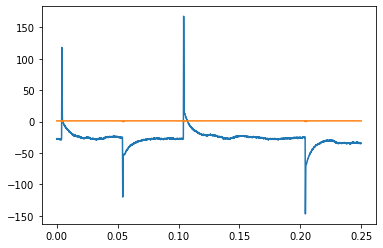

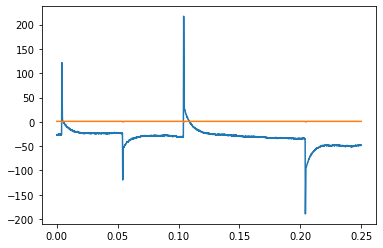

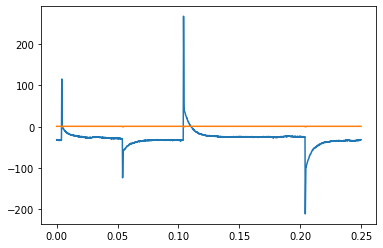

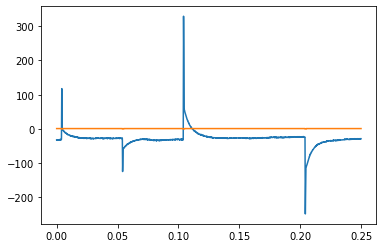

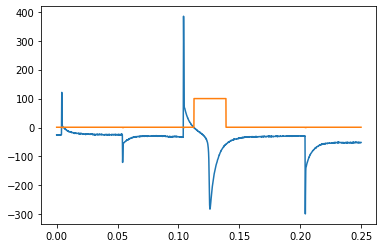

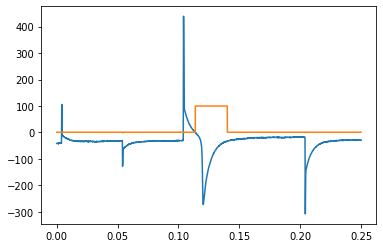

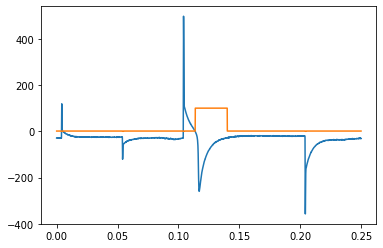

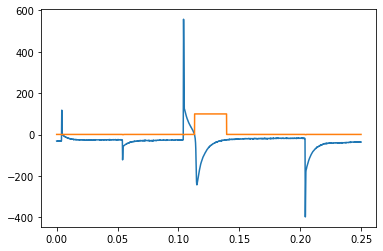

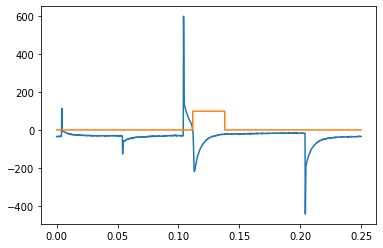

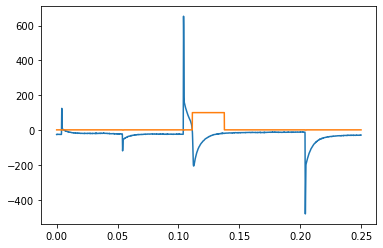

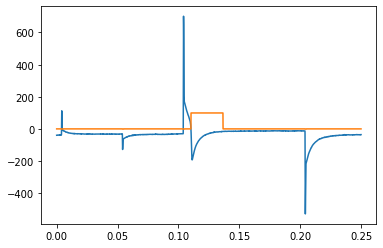

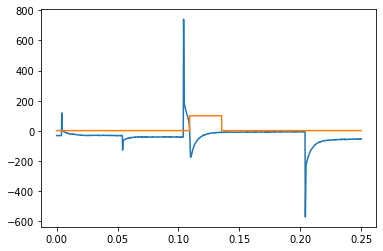

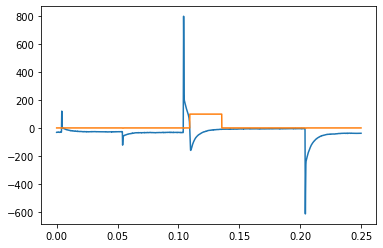

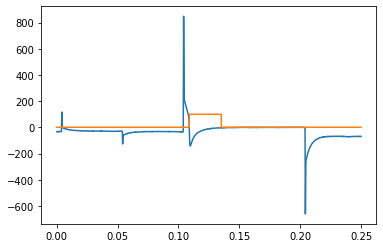

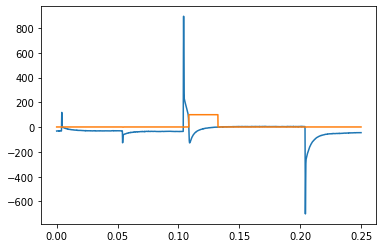

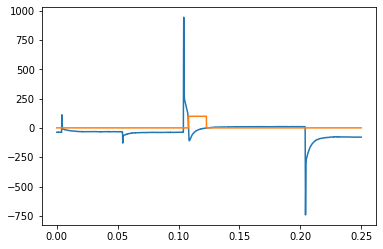

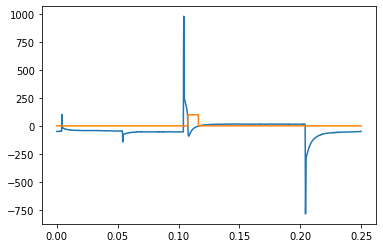

In [11]:
for sweep in weight:
    if sweep =='t':
        continue
    plt.figure()
    plt.plot(trace.t, trace[sweep])
    plt.plot(weight.t, weight[sweep])

In [13]:
# Save weight
weight_name = 'activation.csv'
weights_dir = '../data/weights'

weight = weight.set_index('t')
weight.to_csv(os.path.normpath(os.path.join(weights_dir, weight_name)))